# FastAI for coders - Artigo 8

- Aluno: Bruno Martins Valério Bomfim
- Matrícula: 211039297
- Github: gitbmvb
- Disciplina: Aprendizado de Máquina (FGA0083)
- Semestre: 2023.1

## 1. Introdução
Nesse artigo são contemplados os temas abordados na lição 8 sobre Redes Neurais Convolucionais (CNNs), do curso "Machine Learning for Coders", de Jeremy Howard. O objetivo é produzir um modelo de CNN que consiga classificar imagens de instrumentos musicais (piano e cravo) através da biblioteca fastAI e também por meio de um modelo próprio.

## 2. Pré-requisitos
Para esta finalidade, as bibliotecas necessárias são as do fastAI, PyTorch e duckduckgo, para buscar imagens que constituirão os conjuntos de treinamento de validação.

In [13]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastcore.all import *
from time import sleep

## 3. Abordagem teórica
Alguns conceitos aprendidos durante a lição:

- Maxpooling: operação que reduz a dimensão de uma matriz. Consiste em dividir uma imagem de entrada em regiões sobrepostas e seleciona o valor máximo em cada região - reduzindo a quantidade de parâmetros e informações nas camadas subsequentes, ajudando a tornar a rede mais eficiente computacionalmente.
- Dropout layers: técnica de regularização usada em redes neurais para evitar o overfitting. Uma camada de dropout aleatoriamente desativa um subconjunto de neurônios durante o treinamento, impedindo que eles contribuam para a propagação do erro e a atualização dos pesos.
- Padding: adicionar pixels adicionais ao redor das bordas de uma imagem de entrada para preservar o tamanho da imagem após a aplicação de operações de convolução ou pooling.
- Stride: determinar o deslocamento entre os filtros ou janelas de pooling ao percorrer uma imagem de entrada. Um stride maior resulta em uma redução no tamanho da saída, enquanto um stride menor preserva mais informações espaciais.

## 4. Dados
Iremos obter as imagens de piano e cravo por meio da biblioteca duckduckgo_search, por meio desta função criada pelo Jemery:

In [14]:
def search_images(term, max_images=500):
    print(f"Pesquisando por '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

A partir disto, vamos pesquisar as imagens na plataforma duckduckgo:

In [15]:
searches = 'piano','harpsichord'
path = Path('images')

for s in searches:
    dest = (path/s)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{s} photo'))
    sleep(10)
    resize_images(path/s, max_size=400, dest=path/s)

Pesquisando por 'piano photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Pesquisando por 'harpsichord photo'


Limpando as imagens que tiveram algum erro:

In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

As imagens serão postas em um datablock, uma classe do fastAI que permitirá usá-las nos modelos que iremos criar:

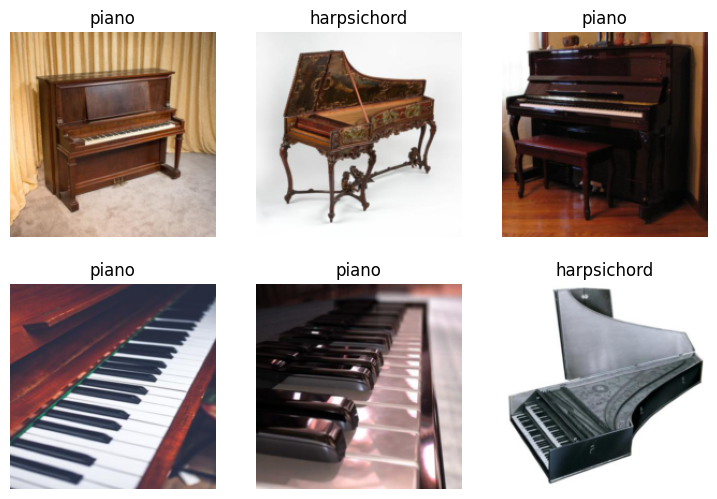

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## 5. Modelagem
A modelagem será composta por duas etapas:

- 1º: criar um modelo de CNN com a resnet50, por meio das funções-padrão do fastAI;
- 2º: criar um modelo próprio, seguindo o passo a passo de Jemery na lição;

### 5.1. Modelagem com resnet50

In [18]:
model = models.resnet50

In [34]:
learn = cnn_learner(dls, model, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Irei utilizar 5 épocas:

In [35]:
learn.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.909366,0.513168,0.781250,00:35
1,0.537360,0.199081,0.968750,00:33
2,0.363112,0.230432,0.968750,00:33
3,0.267467,0.230006,0.937500,00:34
4,0.209096,0.225718,0.937500,00:34


### 5.2. Modelagem manual

In [21]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [26]:
simple_cnn = sequential(
    conv(3 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [36]:
learn2 = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [44]:
learn2.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.920114,2.895039,0.531250,00:01
1,2.889161,2.803040,0.531250,00:01
2,2.846772,2.727579,0.531250,00:01
3,2.808418,2.689820,0.531250,00:01
4,2.779627,2.682413,0.531250,00:01


## 6. Inferência

Reposta da resnet50: harpsichord.
Probabilidade de ser um cravo: 1.0000000000
Probabilidade de ser um piano: 0.0000000000


Reposta da resnet50: piano.
Probabilidade de ser um cravo: 0.0000000098
Probabilidade de ser um piano: 1.0000000000


Reposta da resnet50: harpsichord.
Probabilidade de ser um cravo: 0.9999852180
Probabilidade de ser um piano: 0.0000148035


Reposta da resnet50: harpsichord.
Probabilidade de ser um cravo: 1.0000000000
Probabilidade de ser um piano: 0.0000000204


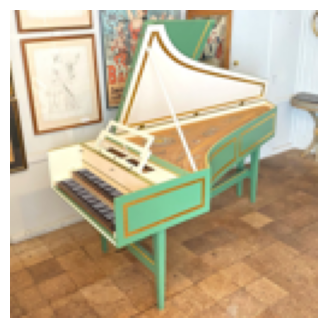

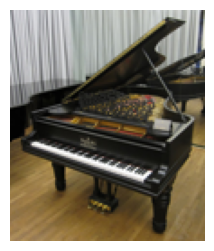

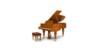

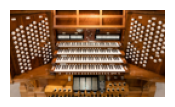

In [31]:
for item in ["cravo", "piano", "piano2", "orgao"]:
    category,_,probs = learn.predict(PILImage.create(f'./testing/testing_{item}.JPG'))
    show_image(Image.open(f'./testing/testing_{item}.JPG').to_thumb(128, 128))
    print(f"Reposta da resnet50: {category}.")
    print(f"Probabilidade de ser um cravo: {probs[0]:.10f}")
    print(f"Probabilidade de ser um piano: {probs[1]:.10f}")

## 7. Deploy

In [56]:
learn.export("model.pkl")

Acesse o deploy do modelo [aqui](https://huggingface.co/spaces/brunomartins/lesson8).

## 8. Conclusões e considerações finais
Através dessa lição, foi possível ter uma noção introdutória sobre redes neurais convolucionais e suas nuances. Criamos um modelo manualmente, definindo a quantidades de camadas e nós entre as camadas, e outro utilizando as classes-padrão do fastAI.

## 9. Bibliografia
**HOWARD, Jemery; GUGGE, Sylvain**. FastBook. Disponível [aqui](https://github.com/fastai/fastbook).

**HOWARD, Jemery**. Lesson 8 - Practical Deep Learning for Coders 2022. Disponível [aqui](https://www.youtube.com/watch?v=htiNBPxcXgo0).